# 2020数字中国创新大赛—算法赛：智慧海洋建设

竞赛链接：https://tianchi.aliyun.com/competition/entrance/231768/information

在这个比赛之间，我一直觉得我能提出很多想法，而且还有baseline，应该会比较容易，但是实际情况是面对数据的无力感，不知道试用什么模型，不知道怎么分析数据，不知道怎么处理数据，只知道不断地跑程序，稍微调一点参数，希望运气好能够获得好的效果，于是最终自己十分的无力。多亏从老师那里获得了一点思路，使得比赛能够进行下去。在初赛的时候，依靠运气得以进入复赛，但是我也是明白的，一直都没有能够提出比较好的方案，而且还是不太明白怎么做。
***
不过，通过这次比赛，我明白了很多，知道特征应该是怎么提取，模型应该是怎么建立，但是不足的地方更多，要学的东西也更多，以前是管中窥豹，狂妄自大，现在看看，小聪明根本没有用，真正的是才是王道。

## 数据

初赛提供11000条渔船北斗数据，数据包含脱敏后的渔船ID(ship)、经纬度坐标(x,y)、上报时间(time)、速度(v)、航向信息(d)，
由于真实场景下海上环境复杂，经常出现信号丢失，
设备故障等原因导致的上报坐标错误、上报数据丢失、甚至有些设备疯狂上报等。

## 评价指标

$$\begin{array}{c}
\text { Score }= \frac { F 1_{\text {围网}}+F 1_{\text {拖网}}+F 1_{\text 刺网} } {3}\\
F 1=\frac{2 * \mathrm{P} * \mathrm{R}}{\mathrm{P}+\mathrm{R}}
\end{array}$$

## 问题分析

这是一个三分类问题，要求我们根据每条船上报的数据（初赛每条船平均300多条，复赛平均400条左右），来分辨这条船是在进行什么作业。但是数据噪声很多，因此主要的目标就是扩充样本和提取特征。其中初赛一共2699638条数据，可用于训练的样本只有7000条，，复赛一共4889341条数据，可用于训练的样本有8166条。
***
注意：初赛和复赛的数据集使用的坐标系不一样。
***
**时间特征**：所有船的作业时间都为3-4天，意味的各船之间以秒作为单位的时间跨度的差距是比较明显的。另外，考虑到不同作业主要的工作时间，小时出现的频率可能也有意义。
***
**常规统计特征**：对位置，速度，航向各自提取最大值、最小值、平均值、中位数、分位数、标准差等常规特征。
***
**数据扩充**：主要使用划窗扩充和按序号分离扩充。

*（数据文件夹tcdata和expand_data放在上一级目录中）*

## EDA

In [4]:
import pandas as pd
import numpy as np
import os
import tqdm
from sklearn import linear_model
import matplotlib.pyplot as plt

df = pd.read_csv('../all.csv')

将时间字符串转化为时间戳

In [5]:
%%time
df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')

Wall time: 11.6 s


#### 简单画图分析

In [31]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

train = pd.read_csv('../all.csv')
numbers = []

for ship in tqdm(range(7000)):
    tmp = train[train['ship'] == ship]
    if tmp['x'].nunique() == 1 or tmp['y'].nunique() == 1:
        numbers.append(ship)

ships = []
for ship in tqdm(numbers):
    ships.append( train[train['ship'] == ship].copy() )

labels = []
for df in tqdm(ships):
    labels.append( df['type'][0] )

100%|█████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:48<00:00, 143.93it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [32]:
def extract_dt(df):
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    df['weekday'] = df['time'].dt.weekday
    return df
train = extract_dt(train)

In [33]:
tuos = []
weis = []
cis = []
for ship in tqdm(range(20000,20000+8166)):
    if train[train['ship'] == ship]['type'].iloc[0] == '拖网':
        tuos.append( ship )
    if train[train['ship'] == ship]['type'].iloc[0] == '围网':
        weis.append( ship )
    else:
        cis.append( ship )
boat = [ tuos , weis , cis ]
dic = {0:'围网',1:'拖网',2:'刺网'}
def show_line(x,y,random = True,t = 0 , k = -1):
    if not random :
        t = np.random.randint(3)
    print(dic[t])
    if k == -1:
        k = np.random.randint( len(boat[t]) )
        print(boat[t][k])
        k = boat[t][k]
    tmp = train[train['ship'] == k]
    plt.figure(figsize = (10,10))
    plt.plot(tmp[x] , tmp[y])
    return tmp.copy()
tmp = train[train['ship'] == 25698]
tmp.sort_values('v')['v'].quantile(0.9)

100%|██████████████████████████████████████████████████████████████████████████████| 8166/8166 [01:51<00:00, 72.98it/s]


0.32

拖网


D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


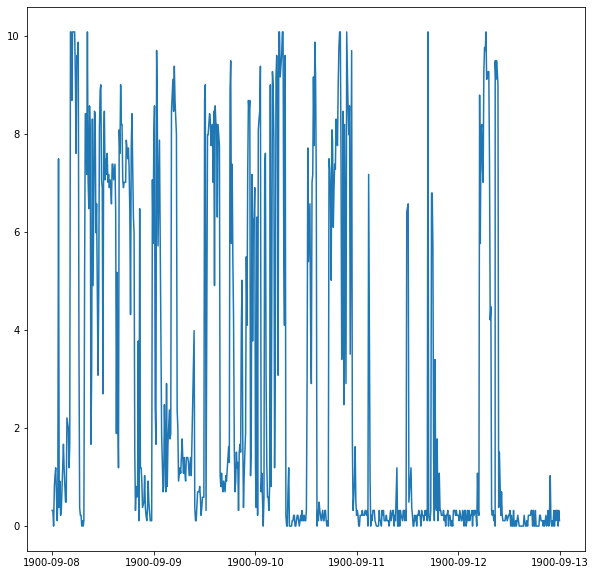

In [34]:
df = show_line('time'  ,'v' , t = 1 , k = 20866).reset_index()

#### 把数据分为三段分别进行分析

画图函数，输出以下内容：
***
1、当前船编号，当前船作业类型。
***
2、使用线性回归拟合x，y，使用最小二乘法求出系数a，b。
***
3、把数据切分为三分然后画图。
***
4、3与2的角度之差，2与1的角度之差。

In [ ]:
#Sample
#25178 围网
#21200 拖网
#27595 刺网

In [35]:
def ALS(x,y):
    ans = []
    try:
        ans = np.array(np.mat(x.T@x).I@np.mat(x.T@y))
    except:
        ans = np.array( np.linalg.pinv( np.mat(x.T@x) )@np.mat(x.T@y))
    return ans
def show_three(df):
    print(df['ship'][:1])
    print(df['type'][:1])
    tmp = int(len(df)/3)
    kmp = int(tmp * 2)
    ls = []
    ls.append(df[:tmp])
    ls.append(df[tmp:kmp])
    ls.append(df[kmp:])
    plt.figure(figsize=(6,6),dpi=80)
    ang = []
    plt.figure(1)
    ax1 = plt.subplot(1,1,1)
    plt.scatter(ls[0]['x'],ls[0]['y'])
    x = pd.DataFrame(ls[0]['x'])
    x['b'] = 1
    w=ALS(x.values , ls[0]['y'].values.reshape(len(ls[0]),1))
    w = np.array(w)
    w=w.flatten()
    print('first line','a :' ,w[0] , 'b : ' , w[1])
    ang.append(w[0])
    plt.figure(2)
    ax2 = plt.subplot(1,1,1)
    plt.scatter(ls[1]['x'],ls[1]['y'])
    x = pd.DataFrame(ls[1]['x'])
    x['b'] = 1
    w=ALS(x.values , ls[1]['y'].values.reshape(len(ls[1]),1))
    w = np.array(w)
    w=w.flatten()
    print('second  line','a :' ,w[0] , 'b : ' , w[1])
    ang.append(w[0])
    plt.figure(3)
    ax3 = plt.subplot(1,1,1)
    plt.scatter(ls[2]['x'],ls[2]['y'])
    x = pd.DataFrame(ls[2]['x'])
    x['b'] = 1
    w=ALS(x.values , ls[2]['y'].values.reshape(len(ls[2]),1))
    w = np.array(w)
    w=w.flatten()
    print('third  line','a :' ,w[0] , 'b : ' , w[1])
    ang.append(w[0])
    print('2 - 1 角度差：' , np.arctan(ang[1]) - np.arctan(ang[0]))
    print('3 - 2 角度差：' , np.arctan(ang[2]) - np.arctan(ang[1]))
    print(np.arctan(ang[0]) , np.arctan(ang[1]) , np.arctan(ang[2]))
    print('from net 2 - 1：' , np.arctan((ang[1]-ang[0])/(float(1 + ang[0]*ang[1]))))#*180/np.pi
    print('from net 3 - 2：' , np.arctan((ang[2]-ang[1])/(float(1 + ang[1]*ang[2]))))

848889    21416
Name: ship, dtype: int64
848889    拖网
Name: type, dtype: object
first line a : 4.0 b :  16.0
second  line a : 0.5631126490479801 b :  104.82140232762322
third  line a : 2.61947219906142 b :  55.33205449907109
2 - 1 角度差 -0.8129629300698307
3 - 2 角度差 0.693260793155557
1.3258176636680326 0.5128547335982019 1.2061155267537589
from net 2 - 1 -0.8129629300698306
from net 3 - 2 0.6932607931555571


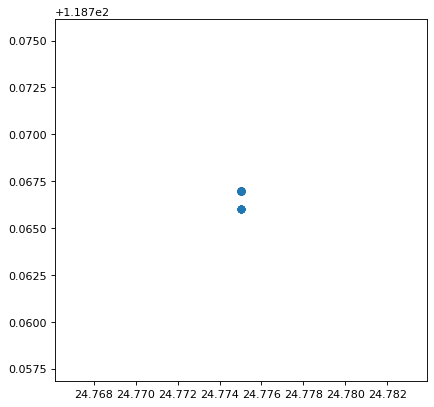

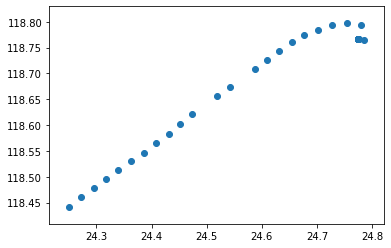

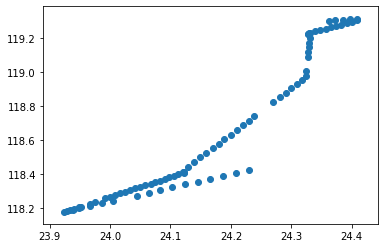

In [24]:
show_three(df[df['ship'] == np.random.randint(20000,28166)])

3098173    25178
Name: ship, dtype: int64
3098173    围网
Name: type, dtype: object
first line a : 0.18212193856015801 b :  116.19982010126114
second  line a : 0.6488417200744152 b :  103.85571789741516
third  line a : 1.1039479617029428 b :  91.76141265034676
2 - 1 角度差 0.3954130124545654
3 - 2 角度差 0.2592036362551787
0.18014752059153746 0.5755605330461029 0.8347641693012816
from net 2 - 1 0.39541301245456545
from net 3 - 2 0.25920363625517884


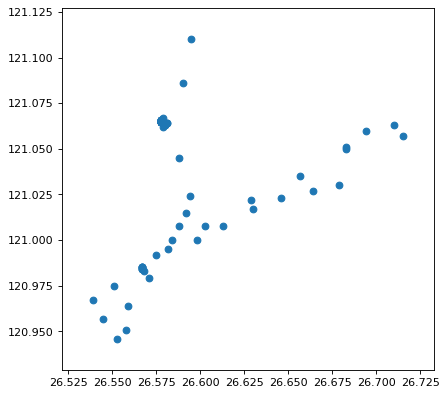

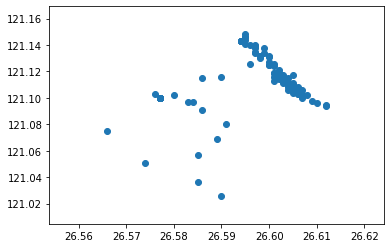

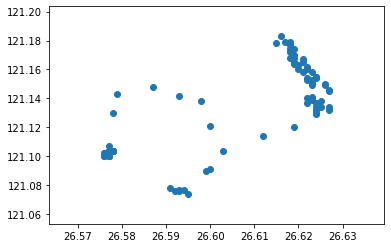

In [25]:
show_three(df[df['ship'] == 25178])

718137    21200
Name: ship, dtype: int64
718137    拖网
Name: type, dtype: object
first line a : -0.35484410139906686 b :  125.73067598871421
second  line a : -0.4535009755054489 b :  127.95661479327828
third  line a : -1.6549813515739515 b :  155.11703145503998
2 - 1 角度差 -0.08477778046825252
3 - 2 角度差 -0.601506113361077
-0.34098374225392675 -0.42576152272217926 -1.0272676360832562
from net 2 - 1 -0.08477778046825246
from net 3 - 2 -0.6015061133610768


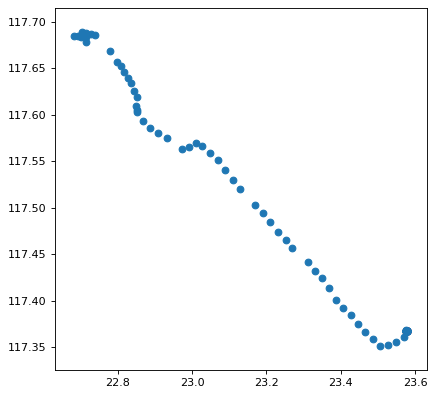

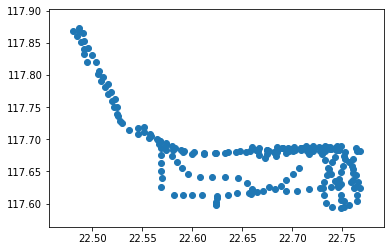

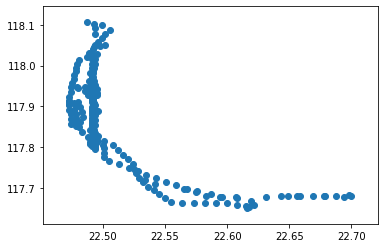

In [26]:
show_three(df[df['ship'] == 21200])

4543273    27595
Name: ship, dtype: int64
4543273    刺网
Name: type, dtype: object
first line a : 0.010189056396484375 b :  117.39846801757812
second  line a : -0.6673805415630341 b :  133.5220594406128
third  line a : -0.9979248046875 b :  141.390625
2 - 1 角度差 -0.5986853656265818
3 - 2 角度差 -0.19586282658079412
0.010188703819797529 -0.5884966618067843 -0.7843594883875784
from net 2 - 1 -0.5986853656265818
from net 3 - 2 -0.19586282658079412


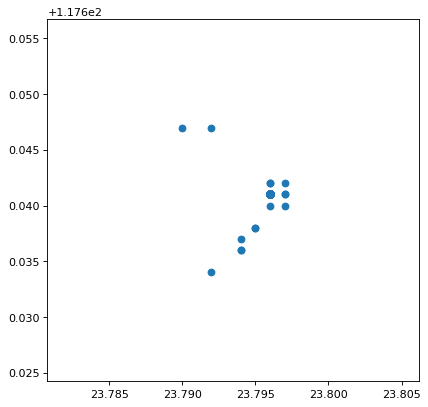

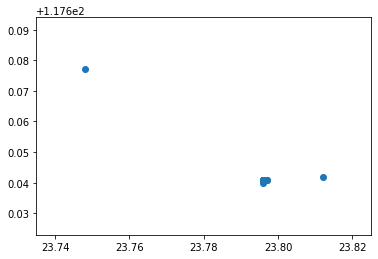

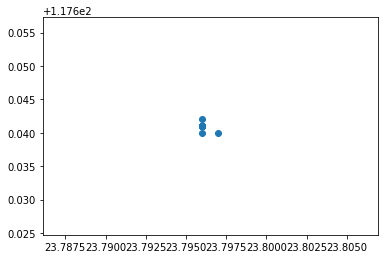

In [27]:
show_three(df[df['ship'] == 27595])

### EDA总结

惭愧的是，通过以上的画图，并没有实质分析出任何有用的特征，也没有挖掘出什么有用的信息，只是得到数据噪声很多这样的信息。不过在后边引发了进行平滑处理的想法。

## 初赛阶段

### 方案一：基于baseline进行修改

#### 方案思路

提取常规统计特征，提取时间中的小时、日期和星期，粗略计算斜率，找出天数和集中地小时工作。另外求x与y平方和并开根号。
***
使用lgb模型和五折交叉验证。
***
特征提取代码如下：

In [31]:
def group_feature(df, key, target, aggs):   
    agg_dict = {}
    for ag in aggs:
        agg_dict[f'{target}_{ag}'] = ag
    print(agg_dict)
    t = df.groupby(key)[target].agg(agg_dict).reset_index()
    return t
def LS(line):
    if line['x_max_x_min']:
        x = np.array([line['x_max_x_min']])
    else :
        x = np.array([0.0001])
    if line['y_max_y_min']:
        y = np.array([line['y_max_y_min']])
    else:
        y = np.array([0.0001])
    x = x.reshape(1,1)
    y = y.reshape(1,1)
    ans = np.mat( (x@x.T) ).I@x.T@y
    return ans[0,0]
def extract_feature(df, train):
    t = group_feature(df, 'ship','x',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','x',['count'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','y',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','v',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','d',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    train['x_max_x_min'] = train['x_max'] - train['x_min']
    train['y_max_y_min'] = train['y_max'] - train['y_min']
    train['y_max_x_min'] = train['y_max'] - train['x_min']
    train['x_max_y_min'] = train['x_max'] - train['y_min']
    train['slope'] = train.apply(lambda x:LS(x) , axis=1)
    train['area'] = train['x_max_x_min'] * train['y_max_y_min']
    
    mode_hour = df.groupby('ship')['hour'].agg(lambda x:x.value_counts().index[0]).to_dict()
    train['mode_hour'] = train['ship'].map(mode_hour)
    
    t = group_feature(df, 'ship','hour',['max','min'])
    train = pd.merge(train, t, on='ship', how='left')
    
    hour_nunique = df.groupby('ship')['hour'].nunique().to_dict()
    date_nunique = df.groupby('ship')['date'].nunique().to_dict()
    train['hour_nunique'] = train['ship'].map(hour_nunique)
    train['date_nunique'] = train['ship'].map(date_nunique)

    t = df.groupby('ship')['time'].agg({'diff_time':lambda x:np.max(x)-np.min(x)}).reset_index()
    t['diff_day'] = t['diff_time'].dt.days
    t['diff_second'] = t['diff_time'].dt.seconds
    train = pd.merge(train, t, on='ship', how='left')
    return train

def extract_dt(df):
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    df['weekday'] = df['time'].dt.weekday
    return df

lgb模型参数如下：

In [29]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',  # 多分类的问题
    'num_class': 3,               # 类别数，与 multisoftmax 并用
    'gamma': 0.2,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 9,               # 构建树的深度，越大越容易过拟合
    'lambda': 0.5,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'silent': 0,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.01,                  # 如同学习率
    'seed': 1000,
}

**方案总结：**  总体来说只是提取的常规特征，并没有比较强的特征，也没有将模型参数调好。

### 方案二：简单线性模型融合

方案思路：基于方案一提取的特征，将xgb、lgb和cab三个模型分别训练，然后线性加权融合。

**方案总结：** 因为三个模型的预测倾向相近，模型融合效果并不好。

### 方案三：暴力提取分位数

方案思路：在方案一的基础上，按照0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99来提取分位数

**方案总结：**效果有了明显的提升。考虑可能是因为数据是离散的，满足某种线性关系。

### 方案四：模型融合（2）

方案思路：基于方案一提取的特征，将xgb模型中三类最大预测概率小于0.6，lgb中三类最大预测概率大于0.8的测试样本替换为lgb的预测结果，其余为xgb预测结果。同时也尝试cab模型。

使用的模型参数如下：

In [32]:
clf=cab.CatBoostClassifier(iterations=2000
                          ,learning_rate=0.1
                          ,depth=8
                          ,loss_function='MultiClass'
                          ,logging_level='Silent'
                          ,class_weights=[2,2,1]
                          ,thread_count=12
                          ,colsample_bylevel = 0.2
                          ,random_seed = 2020)
xlf=xgb.XGBClassifier(max_depth=6
                      ,colsample_bynode=0.1
                      ,learning_rate=0.1
                      ,n_estimators=500
                      ,reg_alpha=0.004
                      ,n_jobs=-1
                      ,reg_lambda=0.002
                      ,importance_type='total_cover'
                      ,objective='multi:softmax')
llf=lgb.LGBMClassifier(num_leaves=32
                       ,max_depth=7
                       ,learning_rate=0.1
                       ,n_estimators=500
                       ,class_weight={0:2,1:3,2:1}
                       ,objective='multiclass'
                       ,n_jobs=-1
                       ,colsample_bytree = 0.7
                       ,min_child_samples = 10
                       ,random_state=2020)

具体融合代码如下：

In [ ]:
res.loc[(np.max(prob_xgb,axis=1)<0.6) & (np.max(prob_lgb,axis=1)>0.8),'merge'] = 
        res.loc[(np.max(prob_xgb,axis=1)<0.6) & (np.max(prob_lgb,axis=1)>0.8),'lgb']

**方案总结：**还是因为预测倾向相似的问题，使得这种融合并没有多少修正。

### 方案五：基于分位数特征的xgb单模型

方案思路：将找到的分位数这一类强特用于xgb模型。改变前四个模型的五折交叉验证的方式，使用全数据进行建模。

**方案总结：**效果很好，但是抖动很大。

### 方案六：划窗来扩充数据

方案思路：使用原始数据的0.8做划窗来扩充数据，选取比较小的间隔，以便能够使得新生成的数据样本能够比较好的覆盖原本数据样本中的模式，最终得到扩充的训练集。
使用该训练集训练xgb模型、lgb模型和cab模型，使用五折交叉验证，其中注意，每一折的验证集还是原本的训练集，只不过训练数据是扩充的训练集。
其中特征提取方式基于方案三，模型参数基于方案四。
***
训练集的扩充代码如下：

In [ ]:
train_target = 'round1_train\\'
index = 0
for f in tqdm(train_csv):
    if '.csv' in f:
        df = pd.read_csv(f'{path_train}{f}')
        df.columns = ['ship' , 'x' , 'y' , 'v' , 'd' , 'time','type']
        interval = int( len(df)*0.8 )
        improve = 10
        start = 0
        df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
        df = df.sort_values(by = 'time')
        while start + interval < len(df):
            tmp = df.iloc[start : start + interval].copy()
            tmp['ship'] = index
            tmp['from'] = df['ship'].iloc[0]
            tmp.to_csv(f'{train_target}{index}.csv')
            start += improve
            index+=1

**方案总结：**不知道为什么，线下效果很好，线上效果反而变差了。

### 方案七：使用二分类模型进行修正

方案思路：先使用基于方案五的模型和特征，然后对其中预测错误率比较高的类单独建立二分类模型去预测。
***
具体代码如下：

In [ ]:
%%time
prob_xgb = np.zeros((len(train_data), 3))
pred_prob_xgb = np.zeros((len(test_data) , 3))
pred_xgb = np.zeros((len(train_data),))
xgb_scores = []

sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)
for train,test in sk.split(train_data,kind):

    x_train=train_data.iloc[train]
    y_train=kind.iloc[train]
    x_test=train_data.iloc[test]
    y_test=kind.iloc[test]
    
    xlf=xgb.XGBClassifier(max_depth=6
                      ,colsample_bynode=0.1
                      ,learning_rate=0.1
                      ,n_estimators=500
                      ,reg_alpha=0.004
                      ,n_jobs=-1
                      ,reg_lambda=0.002
                      ,importance_type='total_cover'
                      ,objective='multi:softmax')
    
    xlf.fit(x_train[features],y_train,sample_weight=kind.map({0:3,1:5.5,2:2.5}))
    
    val_prob_xgb = xlf.predict_proba(x_test[features])
    prob_xgb[test] = val_prob_xgb
    val_pred_xgb = np.argmax(val_prob_xgb, axis=1)
    
    xgb_scores.append(f1_score(y_test, val_pred_xgb, average='macro'))
    print('xgb score :' , xgb_scores[-1])
    
    pred_prob_xgb += xlf.predict_proba(test_data[features])/5

In [ ]:
%%time
prob_xgb = np.zeros((len(train_data), 2))
pred_prob_xgb = np.zeros((len(test_data) , 2))
pred_xgb = np.zeros((len(train_data),))
xgb_scores = []

sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)
for train,test in sk.split(train_data,kind_0):

    x_train=train_data.iloc[train]
    y_train=kind_0.iloc[train]
    x_test=train_data.iloc[test]
    y_test=kind_0.iloc[test]
    
    xlf=xgb.XGBClassifier(max_depth=6
                      ,colsample_bynode=0.1
                      ,learning_rate=0.1
                      ,n_estimators=500
                      ,reg_alpha=0.004
                      ,n_jobs=-1
                      ,reg_lambda=0.002
                      ,importance_type='total_cover'
                         )
    
    xlf.fit(x_train[features],y_train)
    
    val_prob_xgb = xlf.predict_proba(x_test[features])
    prob_xgb[test] = val_prob_xgb
    val_pred_xgb = np.argmax(val_prob_xgb, axis=1)
    
    xgb_scores.append(f1_score(y_test, val_pred_xgb))
    print('xgb score :' , xgb_scores[-1])
    
    pred_prob_xgb += xlf.predict_proba(test_data[features])/5

**方案总结：**修正效果并不明显。

### 方案八：伪标签

方案思路：基于方案五，将其中对测试集得预测结果中最大概率高于某个阈值的样本假设为预测准确的样本，放入训练集中重新训练模型，再次对测试集进行预测。

**方案总结：**效果几乎不变，猜测是样本太少的原因。

### 方案九：两层五折交叉验证

方案思路：在五折交叉验证之后内部再使用一次五折交叉验证。

代码如下：

In [ ]:
outer_scores = []

pred = np.zeros( (len(test_data),3) )

sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)
for index,(train,test) in enumerate(sk.split(train_data,kind)):
    trainset = train_data[features].iloc[train]
    trainkindset = kind.iloc[train]
    testset = train_data[features].iloc[test]
    testkindset = kind.iloc[test]
    fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)
    
    inner_scores = []
    
    prob_test_pred = np.zeros( (len(testset),3) ) 
    inner_pred = np.zeros( (len(test_data),3 ) )
    
    for ind,(tr,te) in enumerate(fold.split(trainset,trainkindset)):
        x_train = trainset.iloc[tr]
        y_train = trainkindset.iloc[tr]
        x_test = trainset.iloc[te]
        y_test = trainkindset.iloc[te]
        
        xlf=xgb.XGBClassifier(max_depth=8
                      ,colsample_bynode=0.1
                      ,learning_rate=0.1
                      ,n_estimators=400
                      ,reg_alpha=0.004
                      ,n_jobs=-1
                      ,reg_lambda=0.002
                      ,importance_type='total_cover'
                      ,objective='multi:softmax')
        
        xlf.fit(x_train , y_train)
        
        inner_val_pred = xlf.predict(x_test)
        inner_scores.append( f1_score(inner_val_pred , y_test , average = 'macro') )
        print(ind , 'f1-score',inner_scores[-1])
        
        prob_test_pred += xlf.predict_proba(testset)/5
        
        inner_pred += xlf.predict_proba(test_data[features])/5
        
    print('-------------------------------------------------------------------------')
    outer_val_pred = np.argmax( prob_test_pred,axis=1 )
    outer_scores.append( f1_score( outer_val_pred ,testkindset , average = 'macro') )
    print(index , 'f1-score' , outer_scores[-1])
    print( 'average score' , np.mean( inner_scores ) )
    print('-------------------------------------------------------------------------')
    
    pred += inner_pred/5

**方案总结：**可能是因为这样导训练数据减少了，效果也不够好。

### 初赛b榜

使用方案五得到最好成绩。

## 初赛之后发现的问题

1、样本量太小一直是一个非常关键的瓶颈。数据扩充也做得比较粗略。
***
2、效果随测试集的分布变化而变化，泛华能力不够好。
***
3、缺少足够的强有力的特征，提取特征不够好，有时候提取的特征比较单一。
***
4、模型使用很不熟练，想xgb和lgb等参数也不是很了解，不能很好地找到较优的参数。
***
5、对数据的分析不够，或者说不会数据分析，只会简单画图，不能通过数据分析获得信息。
***
6、很多地方做的很不好，比如工程能力、信息检索能力和快速学习能力。
***
7、过分追求线下效果，以至于过度调参。
***
8反复跑程序却没有提出太多有效的方案，以至于浪费了太多的时间。

## 复赛阶段

复赛公开了新的训练集，不过其坐标系与初赛训练集的坐标系不同，硬要使用的话效果很不好，在一开始简单尝试了一下去除位置相关的特征，然后同时使用初赛和复赛的训练集进行建模，同样效果不好，这也说明了位置相关特征的重要性吧。同样的，使用坐标转换之后建模效果极差，遂放弃初赛的数据。
***
复赛还有一个困难的地方是使用docker镜像运行，为此学习了一段时间，并自己总结了一下使用docker提交的流程，具体步骤如下：

#### 一、建立docker文件，拉取阿里的基础python镜像 ， 具体Docker文件如下：

#Base Images
***
##从天池基础镜像构建
***
FROM registry.cn-shanghai.aliyuncs.com/tcc-public/python:3
***
##把当前文件夹里的文件构建到镜像的根目录下
***
ADD . /
***
##指定默认工作目录为根目录（需要把run.sh和生成的结果文件都放在该文件夹下，提交后才能运行）
***
WORKDIR /
***
##镜像启动后统一执行 sh run.sh
***
CMD ["bash","run.sh"]

#### 二、安装依赖库，本次需要的库及其版本具体如下：

pandas==0.25.1
***
numpy==1.16.4
***
sklearn==0.21.3
***
tqdm==4.24.0
***
xgboost==0.90
***
catboost==0.21
***
lightgbm==2.3.0

#### 三、启动docker，安装依赖库，运行如下代码，也可以封装在.sh文件中批处理。

pip install -r requirements.txt
***
echo "finished"

#### 四、使用sudo docker ps -a和sudo docker commit 命令保存修改后的镜像

#### 五、准备好源代码文件，准备一个本地测试用的.sh文件，里面封装好必要的命令。具体如下：

-------------------------docker文件-------------------------------
#Base Images
***
##从天池基础镜像构建
***
FROM package:2
***
##把当前文件夹里的文件构建到镜像的根目录下
***
ADD . /
***
##指定默认工作目录为根目录（需要把run.sh和生成的结果文件都放在该文件夹下，提交后才能运行）
***
WORKDIR /
***
##镜像启动后统一执行 sh run.sh
***
CMD ["sh", "run.sh"]

-------------------------------.sh文件-------------------------------
***
sudo docker build -t submit:62 .
***
sudo docker run -it submit:62 /bin/bash
***
sudo docker ps -a

#### 六、将提交命令封装到.sh文件。具体如下：

sudo docker login --username=山隹_子文 registry.cn-shanghai.aliyuncs.com
***
sudo docker tag submit:62 registry.cn-shanghai.aliyuncs.com/czh_test/submit:62
***
sudo docker push registry.cn-shanghai.aliyuncs.com/czh_test/submit:62

**复赛相比较于初赛主要有两点进步：**
***
1、代码结构进行了优化。
***
2、提出了一个较为合理的扩展数据方案。
***
**另外，复赛可以总结为两个主要的方案：**
***
方案一：xgb单模型、xgb与lgb模型融合
***
方案二：数据集分裂后的xgb与lgb模型融合
***
方案三：数据平滑处理

### 方案一

#### 特征提取

In [1]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
warnings.filterwarnings("ignore")

*提取特征函数* *(特征比较单一，只发现分位数这一种比较强的特征)*

In [2]:
features=[]
f = []
def read_information(path,know_type=True , columns = ['ship' , 'x' , 'y' , 'v' , 'd' , 'time','type']):
    global f
    f = []
    df=pd.read_csv(path)
    #提取时间间隔
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    time = df['time'].agg(lambda x:np.max(x) - np.min(x))
    df.columns = columns
    features.append(time.seconds)
    f.append('diff_seconds')
    features.append(df['ship'][0])
    f.append('ship')
    
    df['d'] = df['d'] / 180.0 * np.pi
    df['dis'] = np.sqrt( df['x']**2 + df['y']**2 )
    #暴力提取分位数
    for pos in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]:
        for fea in ['dis','x' , 'y' , 'v' , 'd']:
            features.append(df[fea].quantile(pos))
            f.append(f'{fea}_{pos}')
    #粗略计算速度
    t_diff=df['time'].diff().iloc[1:].dt.total_seconds()
    x_diff=df['x'].diff().iloc[1:].abs()
    y_diff=df['y'].diff().iloc[1:].abs()
    dis=sum(np.sqrt(x_diff**2+y_diff**2))
    x_a_mean=(x_diff/t_diff).mean()
    y_a_mean=(y_diff/t_diff).mean()
    features.append(np.sqrt(x_a_mean**2+y_a_mean**2))#a
    f.append('a')
    #若为训练集则添加类型这一栏
    if(know_type):
        if(df["type"].iloc[0]=='拖网'):
            features.append(2)
        if(df["type"].iloc[0]=='刺网'):
            features.append(1)
        if(df["type"].iloc[0]=='围网'):
            features.append(0)
        f.append('type')

*训练集提取特征* *(只是简单封装一下)*

In [3]:

def get_train(system = 'linux'):
    path_train="/tcdata/hy_round2_train_20200225/"
    if system == 'windows':
        path_train="../tcdata/hy_round2_train_20200225/"
    print('train')    
    print(os.listdir('/'))
    ls = os.listdir(path_train)

    for i in tqdm(ls):
        if '.csv' in i:
            read_information(f'{path_train}{i}',know_type=True)
            
    train_data=pd.DataFrame(np.array(features).reshape(len(ls),int(len(features)/len(ls))))
    train_data.columns=f
    return train_data

*测试集提取特征*

In [4]:
def get_test(system = 'linux'):
    print('testA')
    path_test = "/tcdata/hy_round2_testA_20200225/"
    if system == 'windows':
        path_test = "../tcdata/hy_round2_testA_20200225/"
    ls = os.listdir(path_test)
    for i in tqdm(ls):
        if '.csv' in i:
            read_information(f'{path_test}{i}',know_type=False,columns=['ship' , 'x' , 'y' , 'v' , 'd' , 'time'])
            
    test_data=pd.DataFrame(np.array(features).reshape(len(ls),int(len(features)/len(ls))))
    test_data.columns=f
    print(f)
    return test_data


*开始提取特征*

In [5]:
def extract(system = 'linux'):
    global features
    features = []
    train_data = get_train(system)
    features = []
    test_data = get_test(system)
    features = []
    if system == 'linux':
        train_data.to_csv('/train_data.csv' , index = None)
        test_data.to_csv('/test_data.csv' , index = None)
    else:
        train_data.to_csv('../train_data.csv' , index = None)
        test_data.to_csv('../test_data.csv' , index = None)

#### 模型训练

In [6]:
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cab
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm
import os

warnings.filterwarnings("ignore")

### xgb模型

*封装为一个函数：* 
***
*输入：当前运行平台* 
***
*返回：xgb模型，测试集预测概率矩阵，训练集预测概率矩阵* 
***
*具体包含以下过程：* 
***
*1、读入数据* 
***
*2、五折交叉验证训练模型* 
***
*3、全数据建模* 
***
*4、返回模型融合所需要的信息* 
***

In [7]:
def xgb_model(system = 'linux'):
    #读入数据
    if system == 'linux':
        train_data = pd.read_csv('/train_data.csv')
        test_data = pd.read_csv('/test_data.csv')
    else:
        train_data = pd.read_csv('../train_data.csv')
        test_data = pd.read_csv('../test_data.csv')

    train_data = train_data.sort_values('ship').reset_index()
    test_data = test_data.sort_values('ship').reset_index()

    features = list(set(train_data.columns) - set(['ship','type','from']))
    print('123456789')

    kind=train_data.type
    train_data.drop(['type'],axis=1,inplace=True)
    kind.value_counts(1)

    #五折交叉验证
    prob_xgb = np.zeros((len(train_data), 3))
    pred_prob_xgb = np.zeros((len(test_data) , 3))
    pred_xgb = np.zeros((len(train_data),))
    xgb_scores = []

    sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)
    for train,test in sk.split(train_data[features],kind):
        x_train=train_data.iloc[train]
        y_train=kind.iloc[train]
        x_test=train_data.iloc[test]
        y_test=kind.iloc[test]
    
        xlf=xgb.XGBClassifier(max_depth=6
                      ,colsample_bynode=0.1
                      ,learning_rate=0.1
                      ,n_estimators=1000
                      ,reg_alpha=0.004
                      ,n_jobs=-1
                      ,reg_lambda=0.002
                      ,importance_type='total_cover'
                      ,objective='multi:softmax')
    
        xlf.fit(x_train[features],y_train,sample_weight=kind.map({0:3,1:5.5,2:2.5}))
    
        val_prob_xgb = xlf.predict_proba(x_test[features])
        prob_xgb[test] = val_prob_xgb
        val_pred_xgb = np.argmax(val_prob_xgb, axis=1)
    
        xgb_scores.append(f1_score(y_test, val_pred_xgb, average='macro'))
        print('xgb score :' , xgb_scores[-1])
    
        pred_prob_xgb += xlf.predict_proba(test_data[features])/5


    pred_xgb = np.argmax(prob_xgb , axis=1)
    print('xgb :' , f1_score(pred_xgb, kind, average='macro') )
    print('average : ' , np.mean(xgb_scores) )


    res = pd.DataFrame()
    res['ship'] = test_data['ship']
    res['pred'] = pd.Series(np.argmax(pred_prob_xgb,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})
    res.to_csv('result_xgb_2.csv',header = None , index = None)
    #全数据建模
    xlf=xgb.XGBClassifier(max_depth=6
                      ,colsample_bynode=0.1
                      ,learning_rate=0.1
                      ,n_estimators=1000
                      ,reg_alpha=0.004
                      ,n_jobs=-1
                      ,reg_lambda=0.002
                      ,importance_type='total_cover'
                      ,objective='multi:softmax')
    
    xlf.fit(train_data[features],kind,sample_weight=kind.map({0:3,1:5.5,2:2.5}))
    test_pred_xgb = xlf.predict_proba(test_data[features])
    #返回必要信息
    return xlf , test_pred_xgb , prob_xgb
    #以下是僵尸代码，如果删除上边的返回值，则下面的代码将会运行，从而变为xgb单模型预测。
    res = pd.DataFrame()
    res['ship'] = test_data['ship'].astype('int')
    res['pred'] = pd.Series(np.argmax(test_pred_xgb,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})
    if system == 'linux':
        res.to_csv('/result.csv',header = None , index = None)
    else:
        res.to_csv('../result.csv',header = None , index = None)
    print(os.listdir('/'))

### lgb模型

*下面的函数内容和输入数据均与xgb相同，在此不做赘述*

In [8]:
def lgb_model(system = 'linux'):
    #读入数据
    if system == 'linux':
        train_data = pd.read_csv('/train_data.csv')
        test_data = pd.read_csv('/test_data.csv')
    else:
        train_data = pd.read_csv('../train_data.csv')
        test_data = pd.read_csv('../test_data.csv')
        
    train_data = train_data.sort_values('ship').reset_index()
    test_data = test_data.sort_values('ship').reset_index()

    features = list(set(train_data.columns) - set(['ship','type','from']))

    kind=train_data.type
    train_data.drop(['type'],axis=1,inplace=True)
    kind.value_counts(1)
    #五折交叉验证
    prob_lgb = np.zeros((len(train_data), 3))
    pred_prob_lgb = np.zeros((len(test_data) , 3))
    pred_lgb = np.zeros((len(train_data),))
    lgb_scores = []

    sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)
    for train,test in sk.split(train_data[features],kind):
        x_train=train_data.iloc[train]
        y_train=kind.iloc[train]
        x_test=train_data.iloc[test]
        y_test=kind.iloc[test]
    
        llf=lgb.LGBMClassifier(num_leaves=32
                       ,max_depth=11
                       ,learning_rate=0.1
                       ,n_estimators=500
                       ,class_weight={0:2,1:3,2:1}
                       ,objective='multiclass'
                       ,n_jobs=-1
                       ,colsample_bytree = 0.7
                       ,min_child_samples = 10
                       ,random_state=2020)
    
        llf.fit(x_train[features],y_train)
    
        val_prob_lgb = llf.predict_proba(x_test[features])
        prob_lgb[test] = val_prob_lgb
        val_pred_lgb = np.argmax(val_prob_lgb, axis=1)
    
        lgb_scores.append(f1_score(y_test, val_pred_lgb, average='macro'))
        print('lgb score :' , lgb_scores[-1])
    
        pred_prob_lgb += llf.predict_proba(test_data[features])/5

    pred_lgb = np.argmax(prob_lgb , axis=1)
    print('lgb :' , f1_score(pred_lgb, kind, average='macro') )
    print('average : ' , np.mean(lgb_scores) )

    res = pd.DataFrame()
    res['ship'] = test_data['ship']
    res['pred'] = pd.Series(np.argmax(pred_prob_lgb,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})
    res.to_csv('result_xgb_2.csv',header = None , index = None)
    #全数据建模
    llf=lgb.LGBMClassifier(num_leaves=32
                       ,max_depth=7
                       ,learning_rate=0.1
                       ,n_estimators=600
                       ,class_weight={0:2,1:3,2:1}
                       ,objective='multiclass'
                       ,n_jobs=-1
                       ,colsample_bytree = 0.7
                       ,min_child_samples = 10
                       ,random_state=2020)
    
    llf.fit(train_data[features],kind)
    test_pred_lgb = llf.predict_proba(test_data[features])
    #返回必要信息
    return llf , test_pred_lgb , prob_lgb
    #以下是僵尸代码，如果删除上边的返回值，则下面的代码将会运行，从而变为lgb单模型预测。
    res = pd.DataFrame()
    res['ship'] = test_data['ship'].astype('int')
    res['pred'] = pd.Series(np.argmax(test_pred_lgb,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})
    if system == 'linux':
        res.to_csv('/result.csv',header = None , index = None)
    else:
        res.to_csv('../result.csv',header = None , index = None)
    print(os.listdir('/'))


#### 模型融合

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

*lgb和xgb分别以0.5的权重进行融合，这种简单的线性融合在初赛效果一般，复赛a榜效果较好，但是b榜效果比较差，可能跟测试集的数据分布有关*
***
*输入：当前运行平台*
***
*输出：lgb模型，xgb模型，lgb测试集预测概率矩阵，xgb测试集预测概率矩阵，lgb训练集预测概率矩阵，xgb训练集预测概率矩阵*

In [10]:
def merge(system = 'linux'):
    lmodel , lgb_proba , train_prob_lgb = lgb_model(system)
    xmodel , xgb_probe , train_prob_xgb = xgb_model(system)

    if system == 'linux':
        train_data = pd.read_csv('/train_data.csv')
        test_data = pd.read_csv('/test_data.csv')
    else:
        train_data = pd.read_csv('../train_data.csv')
        test_data = pd.read_csv('../test_data.csv')

    test_pred = lgb_proba * 0.5 + xgb_probe * 0.5
    train_pred = train_prob_lgb * 0.5 + train_prob_xgb * 0.5
    print('merge ' , f1_score(np.argmax(train_pred,axis=1),train_data.type,average = 'macro'))
    
    res = pd.DataFrame()
    res['ship'] = test_data['ship'].astype('int')
    res['pred'] = pd.Series(np.argmax(test_pred,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})
    if system == 'linux':
        res.to_csv('/result.csv',header = None , index = None)
    else:
        res.to_csv('../result.csv',header = None , index = None)
    
    return lmodel , xmodel , lgb_proba , xgb_probe , train_prob_lgb , train_prob_xgb

### 方案二

#### 数据扩展

##### 数据集分割

*假设一条船有n条数据，将3*n分割为一份数据 ， 3*n+1分割为一份数据，3*n+2分割为一份数据*
***
*最终将数据扩充为原先的3倍*

In [11]:
def expand(system = 'linux'):
    print('3 split')
    path_train="/tcdata/hy_round2_train_20200225/"
    if system == 'windows':
        path_train="../tcdata/hy_round2_train_20200225/"
    ls = os.listdir(path_train)
    for i in tqdm(ls):
        if '.csv' in i:
            df = pd.read_csv(f'{path_train}{i}')
            if system == 'windows':
                #对分割的数据做标记，表明是分割的第几份。
                tmp = df[::3]
                tmp['label'] = 1
                tmp.to_csv(f'../expand_data/{i[:-4]}_1.csv' , index = None)
                tmp = df[1::3]
                tmp['label'] = 2
                tmp.to_csv(f'../expand_data/{i[:-4]}_2.csv' , index = None)
                tmp = df[2::3]
                tmp['label'] = 3
                tmp.to_csv(f'../expand_data/{i[:-4]}_3.csv' , index = None)
            else :
                tmp = df[::3]
                tmp['label'] = 1
                tmp.to_csv(f'/expand_data/{i[:-4]}_1.csv' , index = None)
                tmp = df[1::3]
                tmp['label'] = 2
                tmp.to_csv(f'/expand_data/{i[:-4]}_2.csv' , index = None)
                tmp = df[2::3]
                tmp['label'] = 3
                tmp.to_csv(f'/expand_data/{i[:-4]}_3.csv' , index = None)

#### 特征提取（扩展数据）

*与之前的特征提取大致类似*

In [12]:
features=[]
f = []
def read_information(path,know_type=True , columns = ['ship' , 'x' , 'y' , 'v' , 'd' , 'time','type']):
    global f
    f = []
    df=pd.read_csv(path)
    #提取时间间隔
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    time = df['time'].agg(lambda x:np.max(x) - np.min(x))
    df.columns = columns
    features.append(time.seconds)
    f.append('diff_seconds')
    features.append(df['ship'][0])
    f.append('ship')
    
    df['d'] = df['d'] / 180.0 * np.pi
    df['dis'] = np.sqrt( df['x']**2 + df['y']**2 )
    #暴力提取分位数
    for pos in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]:
        for fea in ['dis','x' , 'y' , 'v' , 'd']:
            features.append(df[fea].quantile(pos))
            f.append(f'{fea}_{pos}')
    #粗略计算速度    
    df['time']=pd.to_datetime(df['time'],format='%m%d %H:%M:%S')
    t_diff=df['time'].diff().iloc[1:].dt.total_seconds()
    x_diff=df['x'].diff().iloc[1:].abs()
    y_diff=df['y'].diff().iloc[1:].abs()
    dis=sum(np.sqrt(x_diff**2+y_diff**2))
    x_a_mean=(x_diff/t_diff).mean()
    y_a_mean=(y_diff/t_diff).mean()
    features.append(np.sqrt(x_a_mean**2+y_a_mean**2))#a
    f.append('a')
    #若为训练集则添加类型这一栏 
    if(know_type):
        if(df["type"].iloc[0]=='拖网'):
            features.append(2)
        if(df["type"].iloc[0]=='刺网'):
            features.append(1)
        if(df["type"].iloc[0]=='围网'):
            features.append(0)
        f.append('type')
    #添加数据集标记，表明是第几分数据。
    if 'label' in columns:
        features.append(df['label'][0])
        f.append('label')


*训练集提取特征*

In [13]:
def get_train(system = 'linux'):
    path_train="/tcdata/hy_round2_train_20200225/"
    if system == 'windows':
        path_train="../tcdata/hy_round2_train_20200225/"
    print('train')    
    print(os.listdir('/'))
    ls = os.listdir(path_train)

    for i in tqdm(ls):
        if '.csv' in i:
            read_information(f'{path_train}{i}',know_type=True)
            
    train_data=pd.DataFrame(np.array(features).reshape(len(ls),int(len(features)/len(ls))))
    train_data.columns=f
    return train_data

*测试集提取特征*

In [14]:
def get_test(system = 'linux'):
    print('testA')
    path_test = "/tcdata/hy_round2_testA_20200225/"
    if system == 'windows':
        path_test = "../tcdata/hy_round2_testA_20200225/"
    ls = os.listdir(path_test)
    for i in tqdm(ls):
        if '.csv' in i:
            read_information(f'{path_test}{i}',know_type=False,columns=['ship' , 'x' , 'y' , 'v' , 'd' , 'time'])
            
    test_data=pd.DataFrame(np.array(features).reshape(len(ls),int(len(features)/len(ls))))
    test_data.columns=f
    print(f)
    return test_data

*扩充的训练集提取特征*

In [15]:
def get_expand_train(system = 'linux'):
    path_train="/expand_data/"
    if system == 'windows':
        path_train="../expand_data/"
    print('expand_train')    
    print(os.listdir('/'))
    ls = os.listdir(path_train)

    for i in tqdm(ls):
        if '.csv' in i:
            read_information(f'{path_train}{i}',know_type=True,columns=['ship' , 'x' , 'y' , 'v' , 'd' , 'time','type' , 'label'])
            
    train_data=pd.DataFrame(np.array(features).reshape(len(ls),int(len(features)/len(ls))))
    train_data.columns=f
    print(f)
    return train_data

*开始提取特征*

In [16]:
def extract_expand(system = 'linux'):
    global features
    features = []
    train_data = get_train(system)
    features = []
    test_data = get_test(system)
    features = []
    expand_train_data = get_expand_train(system)
    if system == 'linux':
        train_data.to_csv('/train_data.csv' , index = None)
        test_data.to_csv('/test_data.csv' , index = None)
        expand_train_data.to_csv('/expand_train_data.csv' , index = None)
    else:
        train_data.to_csv('../train_data.csv' , index = None)
        test_data.to_csv('../test_data.csv' , index = None)
        expand_train_data.to_csv('../expand_train_data.csv' , index = None)

#### 模型训练（扩展数据）

### xgb模型


*大致过程与前面的相同，主要不同在于五折交叉验证的时候验证集是原始训练集的数据*
***
*在五折交叉验证中，同时输对未扩展训练集的预测和对扩展训练集的预测*

In [17]:
def xgb_model_expand(system = 'linux'):
    #读入数据
    if system == 'linux':
        train_data = pd.read_csv('/train_data.csv')
        expand_train_data = pd.read_csv('/expand_train_data.csv')
        test_data = pd.read_csv('/test_data.csv')
    else:
        train_data = pd.read_csv('../train_data.csv')
        expand_train_data = pd.read_csv('../expand_train_data.csv')
        test_data = pd.read_csv('../test_data.csv')

    train_data = train_data.sort_values('ship').reset_index()
    expand_train_data = expand_train_data.sort_values(['ship' , 'label']).reset_index()
    test_data = test_data.sort_values('ship').reset_index()

    features = list(set(train_data.columns) - set(['ship','type','from']))
    print('changed10')


#划分特征与目标
    kind=train_data.type
    print(kind.value_counts(1))
    expand_kind_1 = expand_train_data[expand_train_data['label'] == 1].type
    expand_kind_2 = expand_train_data[expand_train_data['label'] == 2].type
    expand_kind_3 = expand_train_data[expand_train_data['label'] == 3].type
    expand_train_data_1 = expand_train_data[expand_train_data['label'] == 1]
    expand_train_data_2 = expand_train_data[expand_train_data['label'] == 2]
    expand_train_data_3 = expand_train_data[expand_train_data['label'] == 3]

    print(expand_train_data_1.values.shape , expand_train_data_2.values.shape , train_data.values.shape)
    print(expand_train_data_3.values.shape)
    #五折交叉验证
    prob_xgb = np.zeros((len(train_data), 3))
    pred_prob_xgb = np.zeros((len(test_data) , 3))
    pred_xgb = np.zeros((len(train_data),))
    expand_prob_xgb = np.zeros( (len(expand_train_data_1),3) )
    expand_pred_xgb = np.zeros( (len(expand_train_data_1),) )
    xgb_scores = []
    expand_xgb_scores = []

    sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)
    for train,test in sk.split(expand_train_data_1[features],expand_kind_1):
        expand_x_train=pd.concat( [expand_train_data_1.iloc[train],expand_train_data_2.iloc[train],train_data.iloc[train],expand_train_data_3.iloc[train]] )
        expand_y_train=pd.concat( [expand_kind_1.iloc[train],expand_kind_2.iloc[train],kind.iloc[train],expand_kind_3.iloc[train] ] )
        expand_x_test=expand_train_data_1.iloc[test]
        expand_y_test=expand_kind_1.iloc[test]
        #-------------------------------------------------------------------------------------------------------
        x_test = train_data.iloc[test]
        y_test = kind.iloc[test]
        #--------------------------------------------------------------------------------------------------
        xlf=xgb.XGBClassifier(max_depth=7
                      ,colsample_bynode=0.1
                      ,learning_rate=0.1
                      ,n_estimators=1000
                      ,reg_alpha=0.04
                      ,n_jobs=-1
                      ,reg_lambda=0.02
                      ,importance_type='total_cover'
                      ,objective='multi:softmax')
        #-----------------------------------------------------------------------------------------------
        xlf.fit(expand_x_train[features],expand_y_train)
        #------------------------------------------------------------------------------------------------
        val_prob_xgb = xlf.predict_proba(x_test[features])
        prob_xgb[test] = val_prob_xgb
        val_pred_xgb = np.argmax(val_prob_xgb, axis=1)
        #--------------------------------------------------------------------------------------------------
        expand_val_prob_xgb = xlf.predict_proba(expand_x_test[features])
        expand_prob_xgb[test] = expand_val_prob_xgb
        expand_val_pred_xgb = np.argmax(expand_val_prob_xgb, axis=1)
        #--------------------------------------------------------------------------------------------------
        xgb_scores.append(f1_score(y_test, val_pred_xgb, average='macro'))
        print('xgb score :' , xgb_scores[-1])
        #---------------------------------------------------------------------------------------------------
        expand_xgb_scores.append(f1_score(expand_y_test, expand_val_pred_xgb, average='macro'))
        print('expand xgb score :' , expand_xgb_scores[-1])
        #-------------------------------------------------------------------------------------------------
        pred_prob_xgb += xlf.predict_proba(test_data[features])/5

    pred_xgb = np.argmax(prob_xgb , axis=1)
    print('xgb :' , f1_score(pred_xgb, kind, average='macro') )
    print('average : ' , np.mean(xgb_scores) )

    res = pd.DataFrame()
    res['ship'] = test_data['ship']
    res['pred'] = pd.Series(np.argmax(pred_prob_xgb,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})
    res.to_csv('result.csv',header = None , index = None)
    #全数据建模
    xlf=xgb.XGBClassifier(max_depth=7
                      ,colsample_bynode=0.1
                      ,learning_rate=0.1
                      ,n_estimators=1000
                      ,reg_alpha=0.04
                      ,n_jobs=-1
                      ,reg_lambda=0.02
                      ,importance_type='total_cover'
                      ,objective='multi:softmax')
    
    xlf.fit(pd.concat([expand_train_data[features],train_data[features]]),pd.concat([expand_train_data.type,kind]))
    test_pred_xgb = xlf.predict_proba(test_data[features])
    return xlf , test_pred_xgb , prob_xgb
    #以下是僵尸代码，如果删除上边的返回值，则下面的代码将会运行，从而变为xgb单模型预测。
    res = pd.DataFrame()
    res['ship'] = test_data['ship'].astype('int')
    res['pred'] = pd.Series(np.argmax(test_pred_xgb,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})
    if system == 'linux':
        res.to_csv('/result.csv',header = None , index = None)
    else:
        res.to_csv('../result.csv',header = None , index = None)
    print(os.listdir('/'))

### lgb模型

*下面符号使用的比较贴近xgb，但是使用的模型就是lgb，只不过改动起来比较麻烦，故保留了符号，修改了模型*

In [18]:
def lgb_model_expand(system = 'linux'):
    #读入数据
    if system == 'linux':
        train_data = pd.read_csv('/train_data.csv')
        expand_train_data = pd.read_csv('/expand_train_data.csv')
        test_data = pd.read_csv('/test_data.csv')
    else:
        train_data = pd.read_csv('../train_data.csv')
        expand_train_data = pd.read_csv('../expand_train_data.csv')
        test_data = pd.read_csv('../test_data.csv')

    train_data = train_data.sort_values('ship').reset_index()
    expand_train_data = expand_train_data.sort_values(['ship' , 'label']).reset_index()
    test_data = test_data.sort_values('ship').reset_index()

    features = list(set(train_data.columns) - set(['ship','type','from']))
    print('changed11')

#划分特征与目标
    kind=train_data.type
    print(kind.value_counts(1))
    expand_kind_1 = expand_train_data[expand_train_data['label'] == 1].type
    expand_kind_2 = expand_train_data[expand_train_data['label'] == 2].type
    expand_kind_3 = expand_train_data[expand_train_data['label'] == 3].type
    expand_train_data_1 = expand_train_data[expand_train_data['label'] == 1]
    expand_train_data_2 = expand_train_data[expand_train_data['label'] == 2]
    expand_train_data_3 = expand_train_data[expand_train_data['label'] == 3]

    print(expand_train_data_1.values.shape , expand_train_data_2.values.shape , train_data.values.shape)
    print(expand_train_data_3.values.shape)
    #五折交叉验证
    prob_xgb = np.zeros((len(train_data), 3))
    pred_prob_xgb = np.zeros((len(test_data) , 3))
    pred_xgb = np.zeros((len(train_data),))
    expand_prob_xgb = np.zeros( (len(expand_train_data_1),3) )
    expand_pred_xgb = np.zeros( (len(expand_train_data_1),) )
    xgb_scores = []
    expand_xgb_scores = []

    sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)
    for train,test in sk.split(expand_train_data_1[features],expand_kind_1):
        expand_x_train=pd.concat( [expand_train_data_1.iloc[train],expand_train_data_2.iloc[train],train_data.iloc[train],expand_train_data_3.iloc[train]] )
        expand_y_train=pd.concat( [expand_kind_1.iloc[train],expand_kind_2.iloc[train],kind.iloc[train],expand_kind_3.iloc[train]] )
        expand_x_test=expand_train_data_1.iloc[test]
        expand_y_test=expand_kind_1.iloc[test]
        #-------------------------------------------------------------------------------------------------------
        x_test = train_data.iloc[test]
        y_test = kind.iloc[test]
        #--------------------------------------------------------------------------------------------------
        xlf=lgb.LGBMClassifier(num_leaves=32
                       ,max_depth=10
                       ,learning_rate=0.1
                       ,n_estimators=1000
                       ,class_weight={0:2,1:3,2:1}
                       ,objective='multiclass'
                       ,n_jobs=-1
                       ,colsample_bytree = 0.7
                       ,min_child_samples = 10
                       ,random_state=2020)
        #-----------------------------------------------------------------------------------------------
        xlf.fit(expand_x_train[features],expand_y_train)
        #------------------------------------------------------------------------------------------------
        val_prob_xgb = xlf.predict_proba(x_test[features])
        prob_xgb[test] = val_prob_xgb
        val_pred_xgb = np.argmax(val_prob_xgb, axis=1)
        #--------------------------------------------------------------------------------------------------
        expand_val_prob_xgb = xlf.predict_proba(expand_x_test[features])
        expand_prob_xgb[test] = expand_val_prob_xgb
        expand_val_pred_xgb = np.argmax(expand_val_prob_xgb, axis=1)
        #--------------------------------------------------------------------------------------------------
        xgb_scores.append(f1_score(y_test, val_pred_xgb, average='macro'))
        print('lgb score :' , xgb_scores[-1])
        #---------------------------------------------------------------------------------------------------
        expand_xgb_scores.append(f1_score(expand_y_test, expand_val_pred_xgb, average='macro'))
        print('expand lgb score :' , expand_xgb_scores[-1])
        #-------------------------------------------------------------------------------------------------
        pred_prob_xgb += xlf.predict_proba(test_data[features])/5

    pred_xgb = np.argmax(prob_xgb , axis=1)
    print('lgb :' , f1_score(pred_xgb, kind, average='macro') )
    print('average : ' , np.mean(xgb_scores) )

    res = pd.DataFrame()
    res['ship'] = test_data['ship']
    res['pred'] = pd.Series(np.argmax(pred_prob_xgb,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})
    res.to_csv('result.csv',header = None , index = None)
    #全数据建模
    xlf=lgb.LGBMClassifier(num_leaves=32
                       ,max_depth=10
                       ,learning_rate=0.1
                       ,n_estimators=1000
                       ,class_weight={0:2,1:3,2:1}
                       ,objective='multiclass'
                       ,n_jobs=-1
                       ,colsample_bytree = 0.7
                       ,min_child_samples = 10
                       ,random_state=2020)
    
    xlf.fit(pd.concat([expand_train_data[features],train_data[features]]),pd.concat([expand_train_data.type,kind]))
    test_pred_xgb = xlf.predict_proba(test_data[features])
    return xlf , test_pred_xgb , prob_xgb
    #以下是僵尸代码，如果删除上边的返回值，则下面的代码将会运行，从而变为lgb单模型预测。
    res = pd.DataFrame()
    res['ship'] = test_data['ship'].astype('int')
    res['pred'] = pd.Series(np.argmax(test_pred_xgb,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})
    if system == 'linux':
        res.to_csv('/result.csv',header = None , index = None)
    else:
        res.to_csv('../result.csv',header = None , index = None)
    print(os.listdir('/'))

#### 模型融合（扩展数据）

*模型融合过程与之前的的一样*

In [19]:
def merge_expand(system = 'linux'):
    lmodel , lgb_proba , train_prob_lgb = lgb_model_expand(system)
    xmodel , xgb_probe , train_prob_xgb = xgb_model_expand(system)

    if system == 'linux':
        train_data = pd.read_csv('/train_data.csv')
        test_data = pd.read_csv('/test_data.csv')
    else:
        train_data = pd.read_csv('../train_data.csv')
        test_data = pd.read_csv('../test_data.csv')

    test_pred = lgb_proba * 0.5 + xgb_probe * 0.5
    train_pred = train_prob_lgb * 0.5 + train_prob_xgb * 0.5
    print('merge ' , f1_score(np.argmax(train_pred,axis=1),train_data.type,average = 'macro'))
    
    res = pd.DataFrame()
    res['ship'] = test_data['ship'].astype('int')
    res['pred'] = pd.Series(np.argmax(test_pred,axis=1))
    res['pred'] = res['pred'].map({0:'围网',1:'刺网',2:'拖网'})#{0:'拖网',1:'围网',2:'刺网'}
    if system == 'linux':
        res.to_csv('/result.csv',header = None , index = None)
    else:
        res.to_csv('../result.csv',header = None , index = None)
    
    return lmodel , xmodel , lgb_proba , xgb_probe , train_prob_lgb , train_prob_xgb


#### 方案三

主要思想是：想通过平滑处理来消除噪声。模型训练方便并没有改变。

In [ ]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

warnings.filterwarnings("ignore")

weights=np.hanning(10)
weights
print(weights.sum())

features=[]
f = []
def read_information(path,know_type=True , columns = ['ship' , 'x' , 'y' , 'v' , 'd' , 'time','type']):
    global f
    global weights
    f = []
    df=pd.read_csv(path)
    
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    time = df['time'].agg(lambda x:np.max(x) - np.min(x))
    df.columns = columns
    features.append(time.seconds)
    f.append('diff_seconds')
    features.append(df['ship'][0])
    f.append('ship')
    #数据平滑处理
    df['x']=np.convolve(weights/weights.sum() , df['x'] , mode = 'same')
    df['y']=np.convolve(weights/weights.sum() , df['y'] , mode = 'same')
    df['v']=np.convolve(weights/weights.sum() , df['v'] , mode = 'same')
    df['d']=np.convolve(weights/weights.sum() , df['d'] , mode = 'same')
    
    df['d'] = df['d'] / 180.0 * np.pi
    df['dis'] = np.sqrt( df['x']**2 + df['y']**2 )

    for pos in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]:
        for fea in ['dis','x' , 'y' , 'v' , 'd']:
            features.append(df[fea].quantile(pos))
            f.append(f'{fea}_{pos}')
    
    for func in ['median']:
        for fea in ['dis','x' , 'y' , 'v' , 'd']:
            features.append(df[fea].agg(func))
            f.append(f'{fea}_{func}')
    
    df['time']=pd.to_datetime(df['time'],format='%m%d %H:%M:%S')
    t_diff=df['time'].diff().iloc[1:].dt.total_seconds()
    x_diff=df['x'].diff().iloc[1:].abs()
    y_diff=df['y'].diff().iloc[1:].abs()
    dis=sum(np.sqrt(x_diff**2+y_diff**2))
    x_a_mean=(x_diff/t_diff).mean()
    y_a_mean=(y_diff/t_diff).mean()
    features.append(np.sqrt(x_a_mean**2+y_a_mean**2))#a
    f.append('a')
 
    if(know_type):
        if(df["type"].iloc[0]=='拖网'):
            features.append(2)
        if(df["type"].iloc[0]=='刺网'):
            features.append(1)
        if(df["type"].iloc[0]=='围网'):
            features.append(0)
        f.append('type')

def get_train(system = 'linux'):
    path_train="/tcdata/hy_round2_train_20200225/"
    if system == 'windows':
        path_train="../tcdata/hy_round2_train_20200225/"
    print('train')    
    print(os.listdir('/'))
    ls = os.listdir(path_train)

    for i in tqdm(ls):
        if '.csv' in i:
            read_information(f'{path_train}{i}',know_type=True)
            
    train_data=pd.DataFrame(np.array(features).reshape(len(ls),int(len(features)/len(ls))))
    train_data.columns=f
    return train_data

def get_test(system = 'linux'):
    print('testA')
    path_test = "/tcdata/hy_round2_testA_20200225/"
    if system == 'windows':
        path_test = "../tcdata/hy_round2_testA_20200225/"
    ls = os.listdir(path_test)
    for i in tqdm(ls):
        if '.csv' in i:
            read_information(f'{path_test}{i}',know_type=False,columns=['ship' , 'x' , 'y' , 'v' , 'd' , 'time'])
            
    test_data=pd.DataFrame(np.array(features).reshape(len(ls),int(len(features)/len(ls))))
    test_data.columns=f
    print(f)
    return test_data

def extract(system = 'linux'):
    global features
    features = []
    test_data = get_test(system)
    features = []
    train_data = get_train(system)
    features = []
    if system == 'linux':
        train_data.to_csv('/train_data.csv' , index = None)
        test_data.to_csv('/test_data.csv' , index = None)
    else:
        train_data.to_csv('../train_data.csv' , index = None)
        test_data.to_csv('../test_data.csv' , index = None)


### 复赛之后发现的问题

1、模型特征单一，几乎只依赖于分位数特征。
***
2、模型泛华能力差，抖动比较剧烈，甚至于测试集的分布一旦改变，就回引起效果的剧烈改变。
***
3、思维不够开阔，没能提出什么有效的方法，由此发现自己的知识严重匮乏。
***
4、pandas和numpy使用不够熟练，很多想法实现比较费时。